# TAOS mars3D: overview daily files

First look at data

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from tqdm import tqdm

import dask
from dask import delayed

from matplotlib import pyplot as plt
%matplotlib inline

from taos import mars as ms

In [2]:
if True:
    
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    #cluster = PBSCluster(processes=4, cores=4) # std
    
    w = cluster.scale(jobs=2)
    
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

---

## load data subset

In [71]:
year = "2010"
year = None

files = ms.browse_files(year=year, daily=True)
print("Number of data files = {} ".format(len(files)))

Number of data files = 3283 


In [4]:
# select 4 times spread over 2010
files_selected = [files.loc["2010-{:2d}-03 12:00:00".format(n), "files"] for n in range(1,12, 3)]
ds = xr.concat([xr.open_dataset(f) for f in files_selected], dim="time")

# add vertical coordinate and eos variables
ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
ds = ms.add_eos(ds)

---

### plot snapshots of surface fields

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

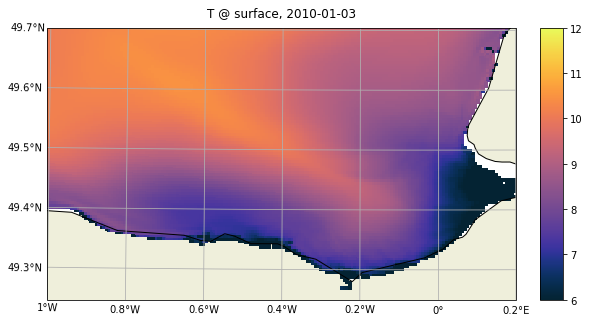

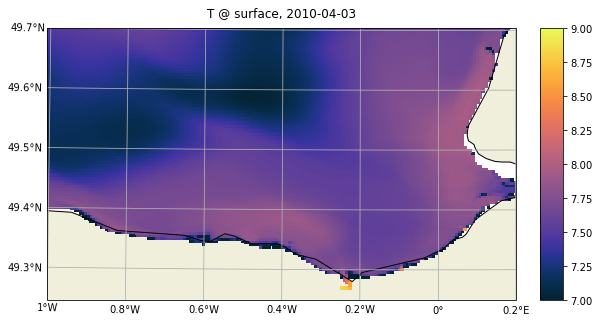

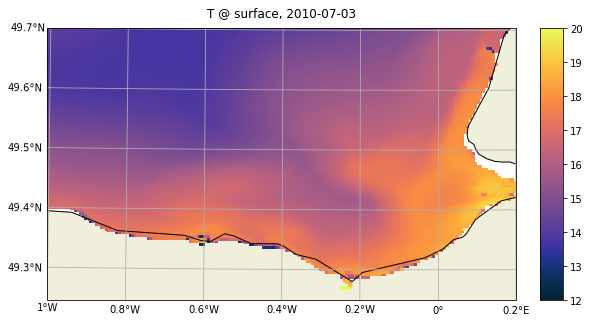

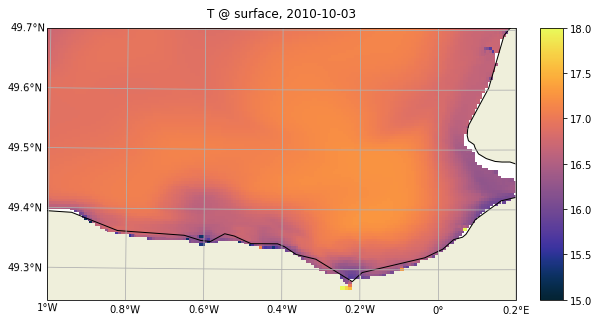

In [13]:
clims = [[6,12], [7,9], [12,20], [15, 18]]
for t, clim in zip(ds.time, clims):
    ms.plot_bs(ds["TEMP"].sel(time=t, level=0, method="nearest"), 
               title="T @ surface, "+str(t.dt.strftime("%Y-%m-%d").values),
               vmin=clim[0], vmax=clim[1],
               cmap=ms.cm.thermal,
               zoom=1, figsize=0,
              )

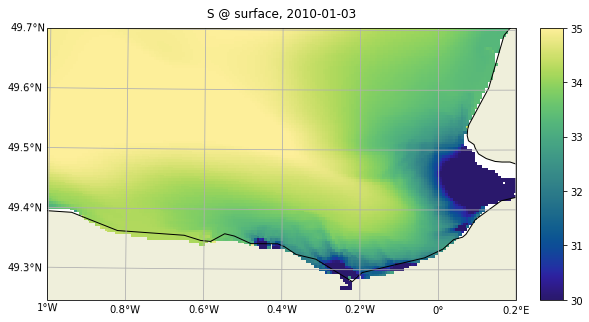

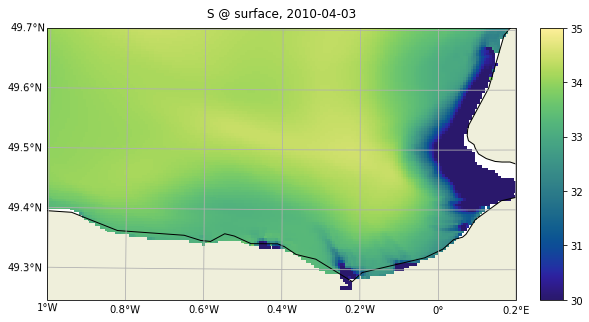

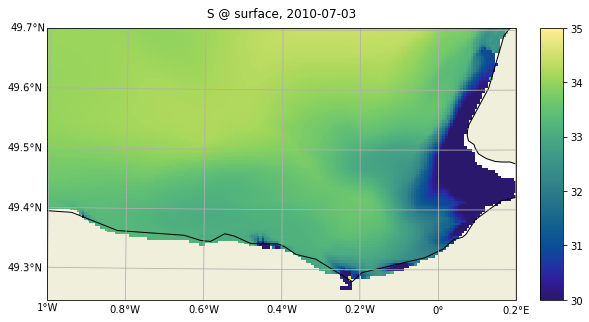

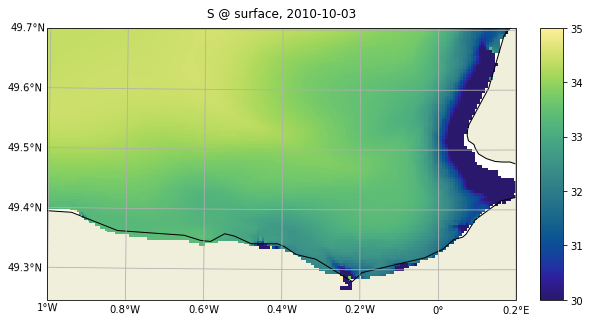

In [14]:
for t, clim in zip(ds.time, clims):
    ms.plot_bs(ds["SAL"].sel(time=t, level=0, method="nearest"), 
               title="S @ surface, "+str(t.dt.strftime("%Y-%m-%d").values),
               vmin=30, vmax=35,
               cmap=ms.cm.haline,
               zoom=1, figsize=0,
              )

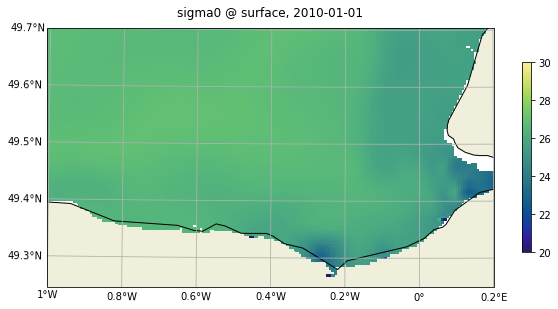

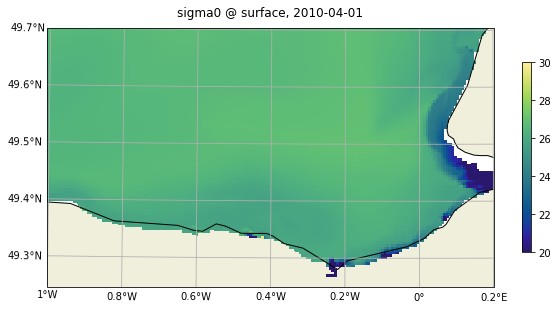

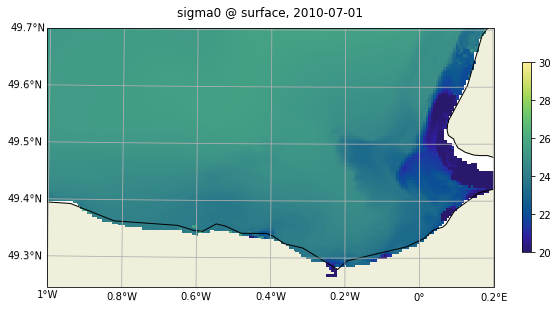

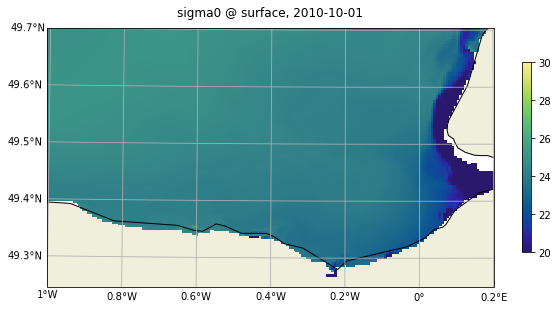

In [11]:
for t, clim in zip(ds.time, clims):
    ms.plot_bs(ds["sigma0"].sel(time=t, level=0, method="nearest"), 
               title="sigma0 @ surface, "+str(t.dt.strftime("%Y-%m-%d").values),
               vmin=20, vmax=30,
               cmap=ms.cm.haline,
               zoom=1, figsize=0,
              )

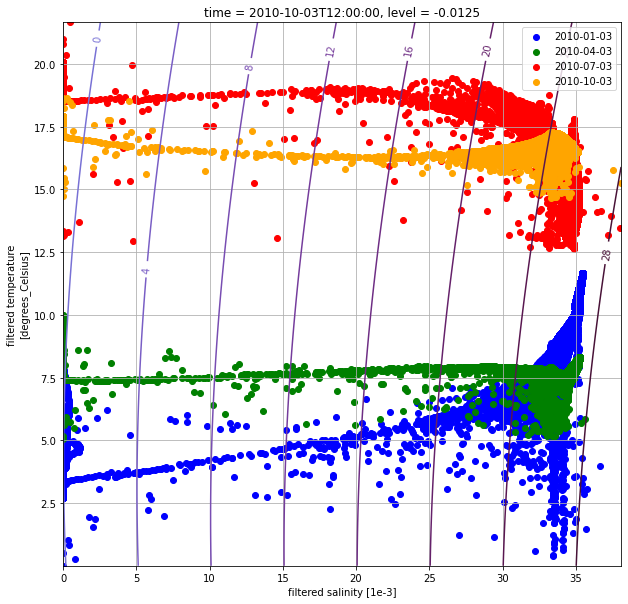

In [15]:
_ds = ds.sel(level=0, method="nearest")
colors = ["b", "g", "r", "orange"]

fig, ax = ms.TS_plot(_ds, t_range=None, s_range=None, figsize=(10,10))

for t, c in zip(_ds.time, colors):
    _dst = _ds.sel(time=t)
    xr.plot.scatter(_dst, y="TEMP", x="SAL", ax=ax, color=c, label=str(t.dt.strftime("%Y-%m-%d").values))
ax.legend()

---

### vertical slices

In [9]:
i = 180
dsi = ds.isel(ni=i, ni_f=i, ni_u=i, ni_v=i).persist()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

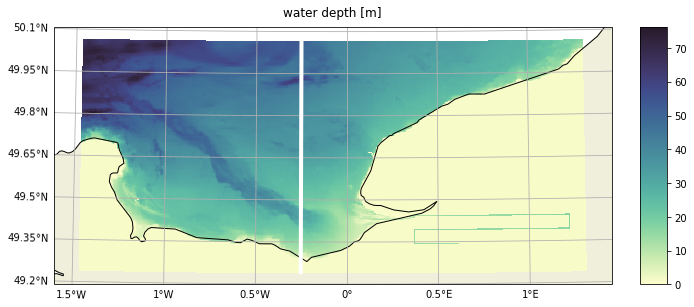

In [10]:
fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
           title="water depth [m]",
           vmin=0,
           cmap=ms.cm.deep,
           zoom=0, figsize=0,
          )

fac["ax"].plot(dsi.longitude, dsi.latitude, 
               color="w", lw=4,
               transform=ms.ccrs.PlateCarree())

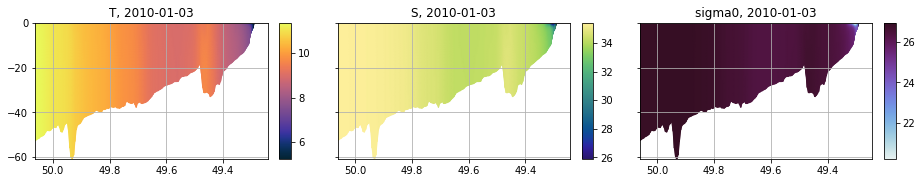

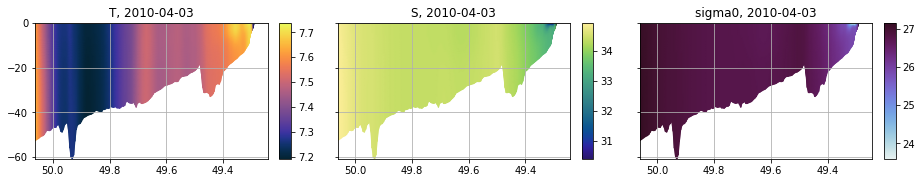

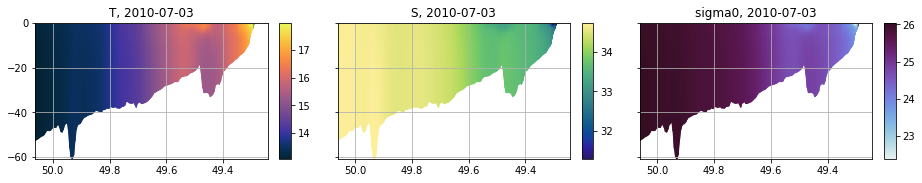

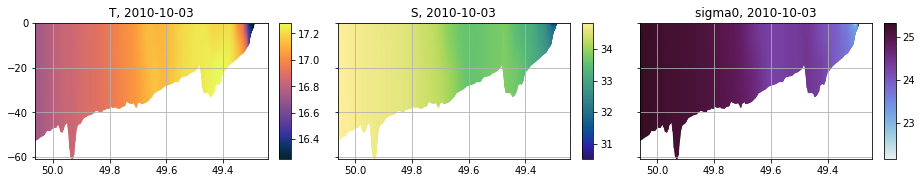

In [11]:
for t in dsi.time:

    _ds = dsi.sel(time=t)
        
    fig = plt.figure(figsize=(15,2.5))
    spec = fig.add_gridspec(ncols=3, nrows=1, wspace=0.3)

    ax = fig.add_subplot(spec[0])    
    ms.plot_section(_ds["TEMP"], "latitude",
                    ax=ax, fig=fig,
                    title="T, "+str(t.dt.strftime("%Y-%m-%d").values),
                    cmap=ms.cm.thermal,
                    colorbar=True,
                    #colorbar_kwargs=cbark,
                   )
    ax = fig.add_subplot(spec[1])
    ms.plot_section(_ds["SAL"], "latitude",
                    ax=ax, fig=fig,
                    title="S, "+str(t.dt.strftime("%Y-%m-%d").values),
                    cmap=ms.cm.haline,
                    ylabel=False,
                   )
    ax = fig.add_subplot(spec[2])    
    ms.plot_section(_ds["sigma0"], "latitude",
                    ax=ax, fig=fig,
                    title="sigma0, "+str(t.dt.strftime("%Y-%m-%d").values),
                    cmap=ms.cm.dense,
                    ylabel=False,
                   )
    

### anomalies with respect to bottom values

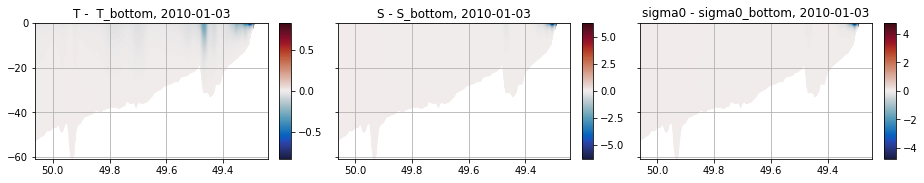

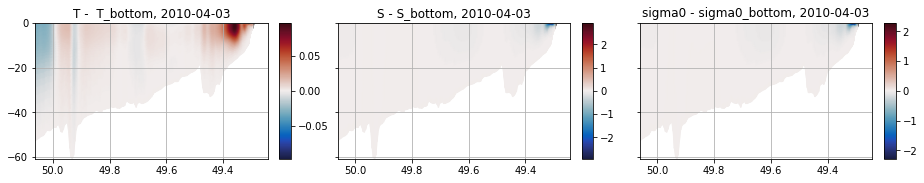

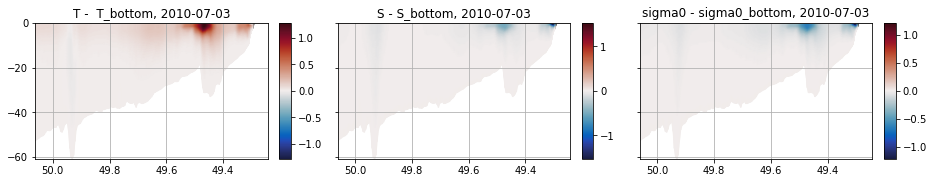

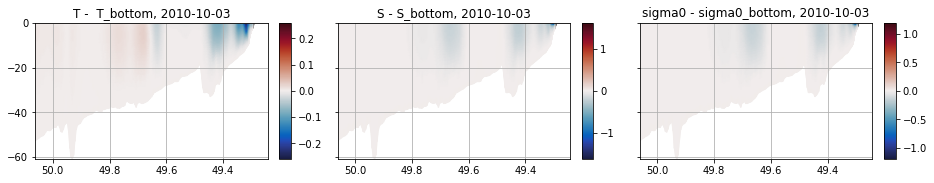

In [12]:
for t in dsi.time:

    _ds = dsi.sel(time=t)
    
    fig = plt.figure(figsize=(15,2.5))
    spec = fig.add_gridspec(ncols=3, nrows=1, wspace=0.3)

    _da = _ds["TEMP"] - _ds["TEMP"].isel(level=0)
    _da["z"] = _ds["z"]
    ax = fig.add_subplot(spec[0])
    ms.plot_section(_da, "latitude",
                    ax=ax, fig=fig,
                    title="T -  T_bottom, "+str(t.dt.strftime("%Y-%m-%d").values),
                    cmap=ms.cm.balance,
                    center_colormap=True,
                   )
    #
    _da = _ds["SAL"] - _ds["SAL"].isel(level=0)
    _da["z"] = _ds["z"]
    ax = fig.add_subplot(spec[1])    
    ms.plot_section(_da, "latitude",
                    ax=ax, fig=fig,
                    title="S - S_bottom, "+str(t.dt.strftime("%Y-%m-%d").values),
                    cmap=ms.cm.balance,
                    center_colormap=True,
                    ylabel=False,
                   )
    #
    _da = _ds["sigma0"] - _ds["sigma0"].isel(level=0)
    _da["z"] = _ds["z"]
    ax = fig.add_subplot(spec[2])
    ms.plot_section(_da, "latitude",
                    ax=ax, fig=fig,
                    title="sigma0 - sigma0_bottom, "+str(t.dt.strftime("%Y-%m-%d").values),
                    cmap=ms.cm.balance,
                    center_colormap=True,
                    ylabel=False,
                   )    
    

### Look at time series of surface and bottom values

In [75]:
import dask
from dask import delayed

In [77]:
i=180
_preprocess = lambda ds: ds.isel(ni=i, ni_f=i, ni_u=i, ni_v=i)

def combine_files(df):
    with dask.config.set(scheduler="threads"):    
        ds = xr.open_mfdataset(list(df["files"]), 
                               concat_dim="time", 
                               preprocess=_preprocess, 
                               combine="nested",
                               coords="minimal",
                               compat="override",
                              )
        return ds.mean("time", keep_attrs=True) # persist here?

combine_files_delayed = delayed(combine_files)

In [78]:
delayed_outputs = [combine_files_delayed(g) for label, g in files.groupby(pd.Grouper(freq="10D"))]
outputs = dask.compute(delayed_outputs)

In [84]:
dsr = (xr.combine_nested(outputs[0], 
                         concat_dim=["time"], 
                         coords="minimal",
                         compat="override",                         
                         #combine_attrs="override",
                        )
       .persist()
      )
dsr["time"] = ("time", list(files.groupby(pd.Grouper(freq="10D")).groups))

dsr

<xarray.Dataset>
Dimensions:      (nj: 183, nj_u: 183, nj_v: 183, level: 40, time: 329, nj_f: 183)
Coordinates: (12/16)
    latitude     (nj) float64 dask.array<chunksize=(183,), meta=np.ndarray>
    latitude_u   (nj_u) float64 dask.array<chunksize=(183,), meta=np.ndarray>
    latitude_v   (nj_v) float64 dask.array<chunksize=(183,), meta=np.ndarray>
  * level        (level) float32 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    longitude    (nj) float64 dask.array<chunksize=(183,), meta=np.ndarray>
    longitude_u  (nj_u) float64 dask.array<chunksize=(183,), meta=np.ndarray>
    ...           ...
    ni_v         float32 180.0
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * nj_f         (nj_f) float32 0.5 1.5 2.5 3.5 4.5 ... 179.5 180.5 181.5 182.5
  * nj_u         (nj_u) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 179.5 180.5 181.5 182.5
  * time         (time) object 2010-01-03T00:00:00+00:00 ... 2018-12-27T00:00...
Data variables: (12/15)
    H0           (time, nj) float32 dask.array<chunksize=(1, 183), meta=np.ndarray>
    hc           (time, nj) float32 dask.array<chunksize=(1, 183), meta=np.ndarray>
    HX           (time, nj_u) float32 dask.array<chunksize=(1, 183), meta=np.ndarray>
    HY           (time, nj_v) float32 dask.array<chunksize=(1, 183), meta=np.ndarray>
    Csu_sig      (time, level) float32 dask.array<chunksize=(1, 40), meta=np.ndarray>
    SIG          (time, level) float32 dask.array<chunksize=(1, 40), meta=np.ndarray>
    ...           ...
    U            (time, nj_u) float32 dask.array<chunksize=(1, 183), meta=np.ndarray>
    V            (time, nj_v) float32 dask.array<chunksize=(1, 183), meta=np.ndarray>
    UZ           (time, level, nj_u) float32 dask.array<chunksize=(1, 40, 183), meta=np.ndarray>
    VZ           (time, level, nj_v) float32 dask.array<chunksize=(1, 40, 183), meta=np.ndarray>
    SAL          (time, level, nj) float32 dask.array<chunksize=(1, 40, 183), meta=np.ndarray>
    TEMP         (time, level, nj) float32 dask.array<chunksize=(1, 40, 183), meta=np.ndarray>

In [ ]:
i = 180
def _load_nc(f):
    ds = xr.open_dataset(f)
    ds = ds.isel(ni=i, ni_f=i, ni_u=i, ni_v=i)
    return ds

#ds = xr.concat([_load_nc(f["files"]) for _, f in files.iterrows()], dim="time")
dsr = (xr.combine_nested([_load_nc(f["files"]) for _, f in files.iterrows()], 
                         concat_dim=["time"], 
                         combine_attrs="override",
                        )
       .persist()
      )

# add vertical coordinate and eos variables
#ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
#ds = ms.add_eos(ds)

KeyboardInterrupt: 

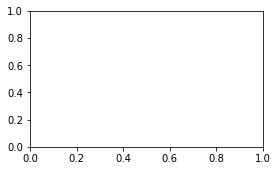

In [85]:
def plot(temp, sal, sigma):

    fig = plt.figure(figsize=(15,2.5))
    spec = fig.add_gridspec(ncols=3, nrows=1, wspace=0.3)

    _da = temp
    ax = fig.add_subplot(spec[0])
    temp.plot(ax=ax, cmap=ms.cm.balance, )

_ds = dsr.isel(level=-1)
plot(_ds.TEMP, _ds.SAL, _ds.TEMP)

---

### make figures for movie: surface properties


In [53]:
def gen_fig(f, v=None, **kwargs):
        
    #dask.config.set(scheduler="threads")
    
    # load and massage file
    ds = xr.open_dataset(f)

    # add vertical coordinate and eos variables
    ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
    ds = ms.add_eos(ds)

    #
    out_dir = "/home1/scratch/aponte/figs/"
    fig_path = out_dir+ds.time.dt.strftime("%Y-%m-%d_%H%M%S").values[0]+".png"
    
    ms.plot_bs(ds[v].sel(level=0, method="nearest"),
               title=v+" @ surface, "+str(ds.time.dt.strftime("%Y-%m-%d %H:%M:%S").values),
               offline=True,
               savefig=fig_path,
               **kwargs
              )
    
    return fig_path

from dask.delayed import delayed
delayed_fig = delayed(gen_fig)

In [12]:
#

file_subset = files["2010-01-01":"2010-02-01"]
file_subset = files["2010-04-01":"2010-05-01"]
file_subset = files["2010-07-01":"2010-08-01"]
#file_subset = files["2010-10-01":"2010-11-01"]

#
#kwargs = dict(v="TEMP", cmap=ms.cm.thermal) # need to be redone
#kwargs = dict(v="TEMP", zoom=1, cmap=ms.cm.thermal)
#kwargs = dict(v="SAL", vmin=30, vmax=35, cmap=ms.cm.haline)
#kwargs = dict(v="SAL", zoom=1, vmin=30, vmax=35, cmap=ms.cm.haline)
kwargs = dict(v="SAL", zoom=1, vmin=30, vmax=35, cmap=ms.cm.haline)


In [ ]:
#
Nb = len(client.nthreads())
rg = range(0, file_subset.size)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]
print('%d batches to be done'%len(II))

for I in tqdm(II):
    #print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(file_subset.iloc[i,0], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

print(" ! done !")

In [26]:
import threading


def gen_fig(f, t=None, s=None, ta=None, sa=None):
    
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        
        plt.switch_backend("agg")
    
        # load and massage file
        ds = xr.open_dataset(f)

        # add vertical coordinate and eos variables
        ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
        ds = ms.add_eos(ds)
            
        #
        out_dir = "/home1/scratch/aponte/figs/"
        fig_path = out_dir+ds.time.dt.strftime("%Y-%m-%d_%H%M%S").values[0]+".png"
        dtime = str(ds.time.dt.strftime("%Y-%m-%d %H:%M:%S").values[0])

        ds = ds.squeeze()

        fig = plt.figure(figsize=(15,10), constrained_layout=False)
        spec = fig.add_gridspec(ncols=2, nrows=2, wspace=0.3, left=.05, right=0.9)
        
        _da = ds["TEMP"].sel(level=0, method="nearest")
        ax = fig.add_subplot(spec[0,0], projection=ms.ccrs.Orthographic(0., 49.5))        
        ms.plot_bs(_da,
               ax=ax, fig=fig,                
               title="T @ surface, "+dtime,
               cmap=ms.cm.thermal,
               **t,
              )
        #
        _da = ds["SAL"].sel(level=0, method="nearest")
        ax = fig.add_subplot(spec[0,1], projection=ms.ccrs.Orthographic(0., 49.5))
        ms.plot_bs(_da,
               ax=ax, fig=fig,
               title="S @ surface, "+dtime,
               cmap=ms.cm.haline,
               **s,
              )
        #
        _da = ds["TEMP"].sel(level=0, method="nearest") - ds["TEMP"].isel(level=0)
        ax = fig.add_subplot(spec[1,0], projection=ms.ccrs.Orthographic(0., 49.5))
        ms.plot_bs(_da,
               ax=ax, fig=fig,
               title="T -  T_bottom, "+dtime,
               cmap=ms.cm.balance,
               #center_colormap=True,
               **ta,
              )
        #
        _da = ds["SAL"].sel(level=0, method="nearest") - ds["SAL"].isel(level=0)
        ax = fig.add_subplot(spec[1,1], projection=ms.ccrs.Orthographic(0., 49.5))
        ms.plot_bs(_da,
               ax=ax, fig=fig,
               title="S @ surface, "+dtime,
               cmap=ms.cm.balance,
               #center_colormap=True,
               **sa,
              )

        #
        fig.savefig(fig_path, dpi=150) #, bbox_inches = "tight"
        plt.close(fig)
        
    return fig_path

from dask.delayed import delayed
delayed_fig = delayed(gen_fig)

In [29]:
#

file_subset = files["2010-01-01":"2010-02-01"]
#file_subset = files["2010-04-01":"2010-05-01"]
#file_subset = files["2010-07-01":"2010-08-01"]
#file_subset = files["2010-10-01":"2010-11-01"]

file_subset = files["2010-01-01":"2011-01-01"]

#
#kwargs = dict(v="TEMP", cmap=ms.cm.thermal) # need to be redone
#kwargs = dict(v="TEMP", zoom=1, cmap=ms.cm.thermal)
#kwargs = dict(v="SAL", vmin=30, vmax=35, cmap=ms.cm.haline)
#kwargs = dict(v="SAL", zoom=1, vmin=30, vmax=35, cmap=ms.cm.haline)

zoom=1
tk = dict(zoom=zoom)
tak = dict(zoom=zoom, vmin=-2, vmax=2)
sk = dict(zoom=zoom, vmin=30, vmax=35)
sak = dict(zoom=zoom, vmin=-10, vmax=10)
kwargs = dict(t=tk, s=sk, ta=tak, sa=sak)

In [30]:
#
Nb = len(client.nthreads())
rg = range(0, file_subset.size)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]
print('%d batches to be done'%len(II))

for I in tqdm(II):
    #print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(file_subset.iloc[i,0], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

print(" ! done !")

250 batches to be done


100%|██████████| 250/250 [16:49<00:00,  4.04s/it]

 ! done !


---

### make figures for movie: vertical slices

In [ ]:
def gen_fig(f, v=None, i=None, j=None, **kwargs):
    
    # load and massage file
    ds = xr.open_dataset(f)
    
    # add vertical coordinate and eos variables
    ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
    ds = ms.add_eos(ds)

    if i is not None:
        ds = ds.isel(ni=i, ni_f=i, ni_u=i, ni_v=i)
    if j is not None:
        ds = ds.isel(ni=j, ni_f=j, ni_u=j, ni_v=j)
        
    #
    out_dir = "/home1/scratch/aponte/figs/"
    fig_path = out_dir+ds.time.dt.strftime("%Y-%m-%d_%H%M%S").values[0]+".png"
    
    ms.plot_section(ds[v], "latitude",
                    ax=axes[0], fig=fig,
                    title=v+" "+str(ds.time.dt.strftime("%Y-%m-%d").values),
                    offline=True,
                    savefig=fig_path,
                    **kwargs,
                   )
    
    return fig_path

from dask.delayed import delayed
delayed_fig = delayed(gen_fig)

In [13]:
import threading

def gen_fig(f, i=None, j=None, t=None, s=None, ta=None, sa=None):
    
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        
        plt.switch_backend("agg")
    
        # load and massage file
        ds = xr.open_dataset(f)

        # add vertical coordinate and eos variables
        ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
        ds = ms.add_eos(ds)

        if i is not None:
            ds = ds.isel(ni=i, ni_f=i, ni_u=i, ni_v=i)
        if j is not None:
            ds = ds.isel(ni=j, ni_f=j, ni_u=j, ni_v=j)
            
        #
        out_dir = "/home1/scratch/aponte/figs/"
        fig_path = out_dir+ds.time.dt.strftime("%Y-%m-%d_%H%M%S").values[0]+".png"
        dtime = str(ds.time.dt.strftime("%Y-%m-%d %H:%M:%S").values[0])

        ds = ds.squeeze()

        fig = plt.figure(figsize=(15,5), constrained_layout=False)
        spec = fig.add_gridspec(ncols=2, nrows=2, wspace=0.3, left=.05, right=0.9)
        
        _da = ds["TEMP"]
        ax = fig.add_subplot(spec[0,0])
        ms.plot_section(_da, "latitude",
                        ax=ax, fig=fig,
                        title="T, "+dtime,
                        cmap=ms.cm.thermal,
                        xlabel=False,
                        **t,
                       )
        #
        _da = ds["SAL"]
        ax = fig.add_subplot(spec[0,1])
        ms.plot_section(_da, "latitude",
                        ax=ax, fig=fig,
                        title="S, "+dtime,
                        cmap=ms.cm.haline,
                        ylabel=False,
                        xlabel=False,
                        **s,
                       )
        #
        _da = ds["TEMP"] - ds["TEMP"].isel(level=0)
        _da["z"] = ds["z"]
        ax = fig.add_subplot(spec[1,0])
        ms.plot_section(_da, "latitude",
                        ax=ax, fig=fig,
                        title="T -  T_bottom, "+dtime,
                        cmap=ms.cm.balance,
                        #center_colormap=True,
                        **ta,
                       )
        #
        _da = ds["SAL"] - ds["SAL"].isel(level=0)
        _da["z"] = ds["z"]
        ax = fig.add_subplot(spec[1,1])
        ms.plot_section(_da, "latitude",
                        ax=ax, fig=fig,
                        title="S - S_bottom, "+dtime,
                        cmap=ms.cm.balance,
                        #center_colormap=True,
                        ylabel=False,
                        **sa
                       )        

        #
        fig.savefig(fig_path, dpi=150) #bbox_inches = "tight"
        plt.close(fig)
        
    return fig_path

from dask.delayed import delayed
delayed_fig = delayed(gen_fig)

In [16]:
#

#file_subset = files["2010-01-01":"2010-01-05"] # dev
#file_subset = files["2010-01-01":"2010-02-01"]
#file_subset = files["2010-04-01":"2010-05-01"]
#file_subset = files["2010-07-01":"2010-08-01"]
#file_subset = files["2010-10-01":"2010-11-01"]

file_subset = files["2010-01-01":"2011-01-01"]

i = 180

#
#kwargs = dict(v="TEMP", cmap=ms.cm.thermal) # need to be redone
#kwargs = dict(v="TEMP", zoom=1, cmap=ms.cm.thermal)
#kwargs = dict(v="SAL", vmin=30, vmax=35, cmap=ms.cm.haline)
#kwargs = dict(v="SAL", i=i, zoom=1, vmin=30, vmax=35, cmap=ms.cm.haline)

kwargs = dict(i=i)

tk = dict()
tak = dict(vmin=-2, vmax=2)
sk = dict(vmin=30, vmax=35)
sak = dict(vmin=-10, vmax=10)
kwargs = dict(**kwargs, t=tk, s=sk, ta=tak, sa=sak)

In [17]:
#
Nb = len(client.nthreads())
rg = range(0, file_subset.size)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]
print('%d batches to be done'%len(II))

for I in tqdm(II):
    #print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(file_subset.iloc[i,0], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

print(" ! done !")

250 batches to be done


100%|██████████| 250/250 [11:48<00:00,  2.83s/it]

 ! done !


---

In [46]:
client.restart()

<Client: 'tcp://10.148.0.230:47356' processes=0 threads=0, memory=0 B>

In [31]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 

In [15]:
for f in futures:
    f.cancel()